University of Padua\
Natural Language Processing course, a.a. 2021/2022\
Alberto Grimaldi, _student ID:_ 2026705
, _email:_ alberto.grimaldi.1@studenti.unipd.it\
Laura Menotti, _student ID:_ 2019172, _email:_ laura.menotti@studenti.unipd.it

---

# Detect hate speech in tweets using roBERTa

The objective of this project is to fine-tune [twitter-roBERTa-base-mar2022](https://huggingface.co/cardiffnlp/twitter-roberta-base-mar2022) to classify racist or sexist tweets from others. The model trained on 128.06M tweets and finetuned for sentiment analysis with the TweetEval benchmark. More details and performance scores are available in the [TimeLMs](https://arxiv.org/abs/2202.03829) paper (Barbieri et al., 2022)

In order to train and test our model we will use the Hugging Face dataset [tweet_hate_speech_detection](https://huggingface.co/datasets/tweets_hate_speech_detection) where each tweet has been labelled '0' if it is not racist/sexist or '1' if it contains hate speech.

Hugging Face is a community and data science platform that provides tools that enable users to build, train and deploy ML models based on open source code and technologies.

This work relies on the Pythorch overview videos from class and on two notebooks, one is [Sentiment Analysis with BERT](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) and the other is [Fine Tuning Roberta for Sentiment Analysis](https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=WTdfPjhFqExX) from the following [Kaggle competition](https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only).

## Setup

In [ ]:
!pip install -q -U watermark

We install the [datasets library](https://huggingface.co/docs/datasets/index) from Hugging Face to access and load the training dataset

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 5.2 MB/s 
     |████████████████████████████████| 140 kB 61.4 MB/s 
     |████████████████████████████████| 212 kB 48.8 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████| 1.1 MB 66.5 MB/s 
     |████████████████████████████████| 596 kB 65.7 MB/s 
     |████████████████████████████████| 127 kB 76.2 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 42.9 MB/s 
     |████████████████████████████████| 271 kB 51.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's depen

We install the [transformers library](https://huggingface.co/docs/transformers/index) from Hugging Face that provides APIs to easily download and train state-of-the-art pretrained models. In fact, we will later load the roBERTa pretrained model from such library.

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 52.1 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers,datasets

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.11.0+cu113
transformers: 4.20.0
datasets    : 2.3.2



In [ ]:
# import libraries for the model and the dataset
import transformers
from transformers import RobertaTokenizer, RobertaModel, AdamW
from datasets import load_dataset

# import standard libraries
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from tqdm import tqdm 

import numpy as np
import pandas as pd

# import libraries for plotting
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from textwrap import wrap
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Setting some useful parameters for plotting
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

# Setting the random seed for pytorch
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# device object that points to the GPU if there is one, otherwise points to the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# printing the device object to see what it points at
device

device(type='cuda', index=0)

## Data Exploration

We load the [tweets_hate_speech_detection dataset](https://huggingface.co/datasets/tweets_hate_speech_detection) from Hugging Face.

In [ ]:
# Loading the dataset
dataset = load_dataset("tweets_hate_speech_detection")
# Save the dataset as a pandas.DataFrame
df = dataset['train'].to_pandas()
df.head()

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (/root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [ ]:
# Printing dataframe information and shape
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


(31962, 2)

We have about 32K trainig instances without missing values. 

We map labels from '0'/'1' respectively to 'no-hate-speech'/'hate-speech' so they are more human-readable.

In [ ]:
def to_sentiment(label):
  """
  Maps labels from an integer number to a more explicative label.

  :param label: (int) input label either 0 or 1.

  :return string 'no-hate-speech' for label 0 and 'hate-speech' for label 1.
  """

  label = int(label)
  if label == 0:
    return 'no-hate-speech'
  else: 
    return 'hate-speech'

# Create a new column with the mapped label
df['sentiment'] = df.label.apply(to_sentiment)

We plot the number of tweets based on the assigned label to check if classes are balanced.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


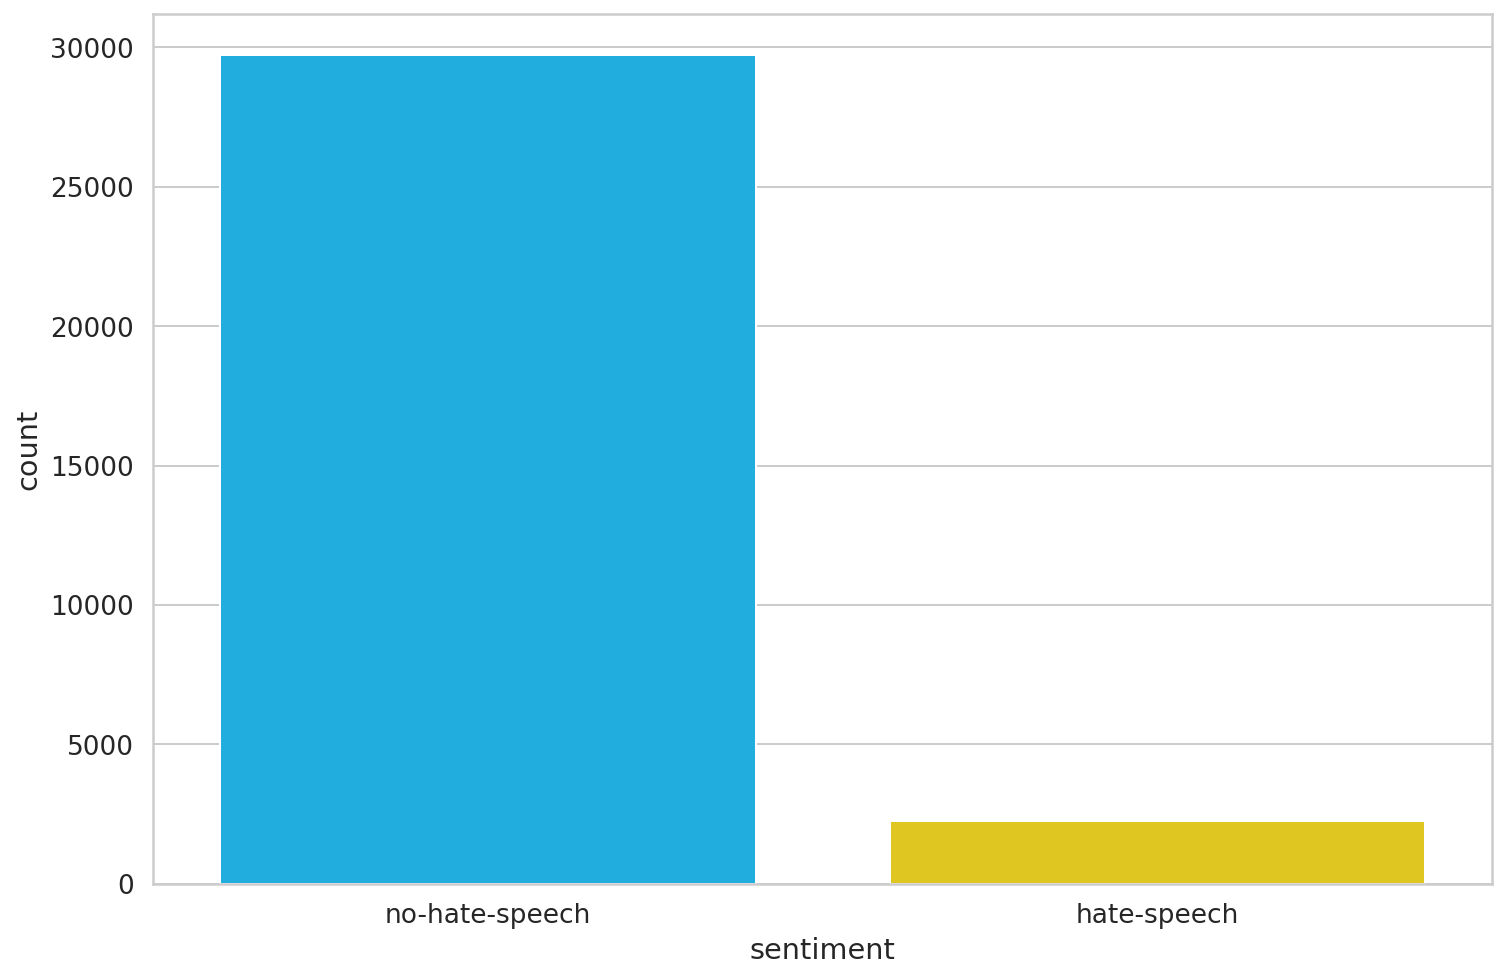

In [ ]:
class_names = ['no-hate-speech', 'hate-speech']
# Plotting the tweets based on sentiment
sns.countplot(df.sentiment)

As we can see data is strongly unbalanced, in fact there are roughly 2500 tweets labelled as 'hate-speech' while there are almost 30K tweets labelled as 'no-hate-speech'.

Let's take a look at the most recurring words in dataset tweets.
We'll use Wordcloud which is a cloud filled with lots of words in different sizes, which represent the frequency or the importance of each word.

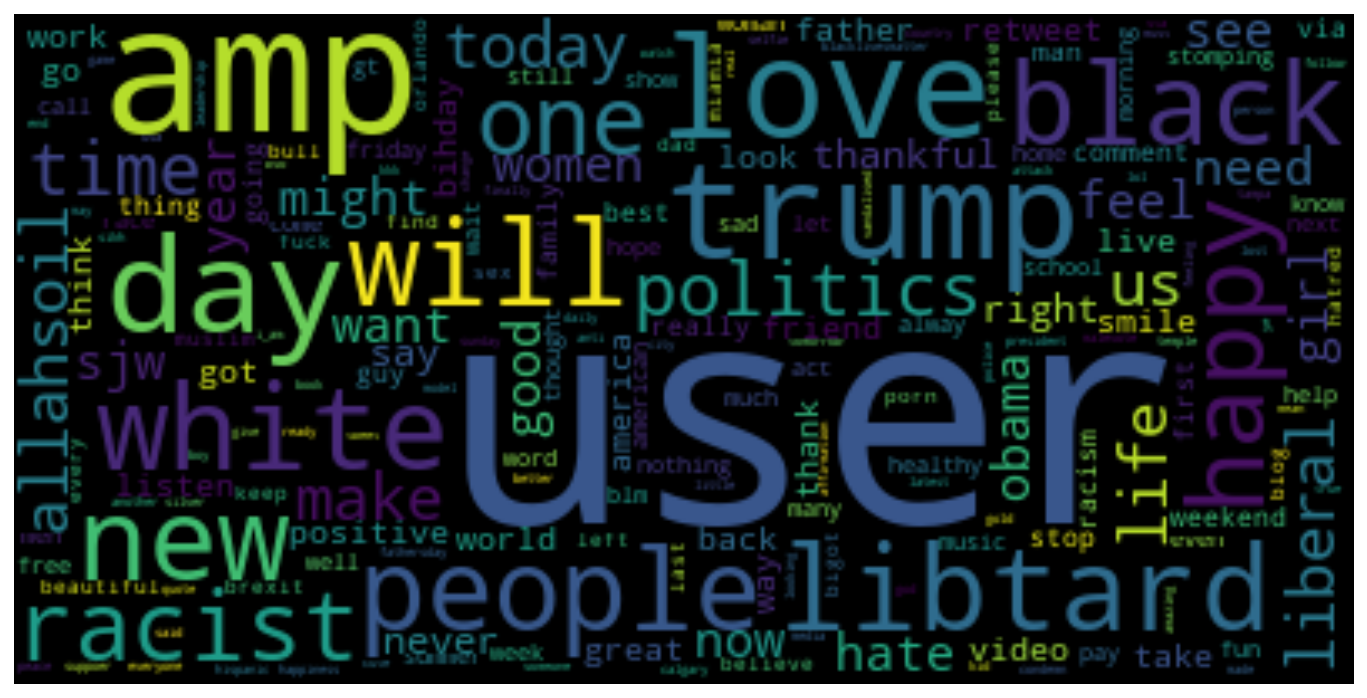

In [ ]:
text = " ".join(tweet for tweet in df.tweet)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update (["",])
# Generate a word cloud image
wordcloud = WordCloud(collocations = False).generate(text)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As we can see the most used words are '**user**', '**amp**', '**libtard**', '**love**', '**trump**', etc.

'amp' probably refers to the ampersand used as abbreviation of 'and'. Since most of the time the tweets are collected by automated chatbot , they store the sign '**&**' like this : '&amp'. To convince us of this it is enough to visualize some comments that contain the word 'amp'.

In [ ]:
df_amp = df[df['tweet'].str.contains('amp')]
df_amp.head(10)

,label,tweet,sentiment
6,0,@user camping tomorrow @user @user @user @user...,no-hate-speech
8,0,we won!!! love the land!!! #allin #cavs #champ...,no-hate-speech
22,0,product of the day: happy man #wine tool who'...,no-hate-speech
64,0,@user my wife whom i adore had to miss your po...,no-hate-speech
73,0,@user ferrari will do itðªð¼ for the sake ...,no-hate-speech
81,0,@user designing #innovative learning space @us...,no-hate-speech
82,1,how the #altright uses &amp; insecurity to lu...,hate-speech
93,0,"daughter riding her bike around driveway, son ...",no-hate-speech
111,1,@user i'm not interested in a #linguistics tha...,hate-speech
131,1,#people aren't protesting #trump because a #re...,hate-speech


The word 'libtard' is used by extreme right-wing people to refer to someone who believes in personal freedom and that money, property, and power should be shared fairly. Libtard is a combination of "liberal" and "retard".

Switching back to the data distribution, in order to have a balanced dataset we may apply an upsampling. 

***Upsampling*** is a procedure where synthetically generated data points (corresponding to minority class) are injected into the dataset. After this process, the counts of both labels are almost the same. This equalization procedure prevents the model from inclining towards the majority class. Furthermore, the interaction(boundary line)between the target classes remains unaltered. And also, the upsampling mechanism introduces bias into the system because of the additional information.

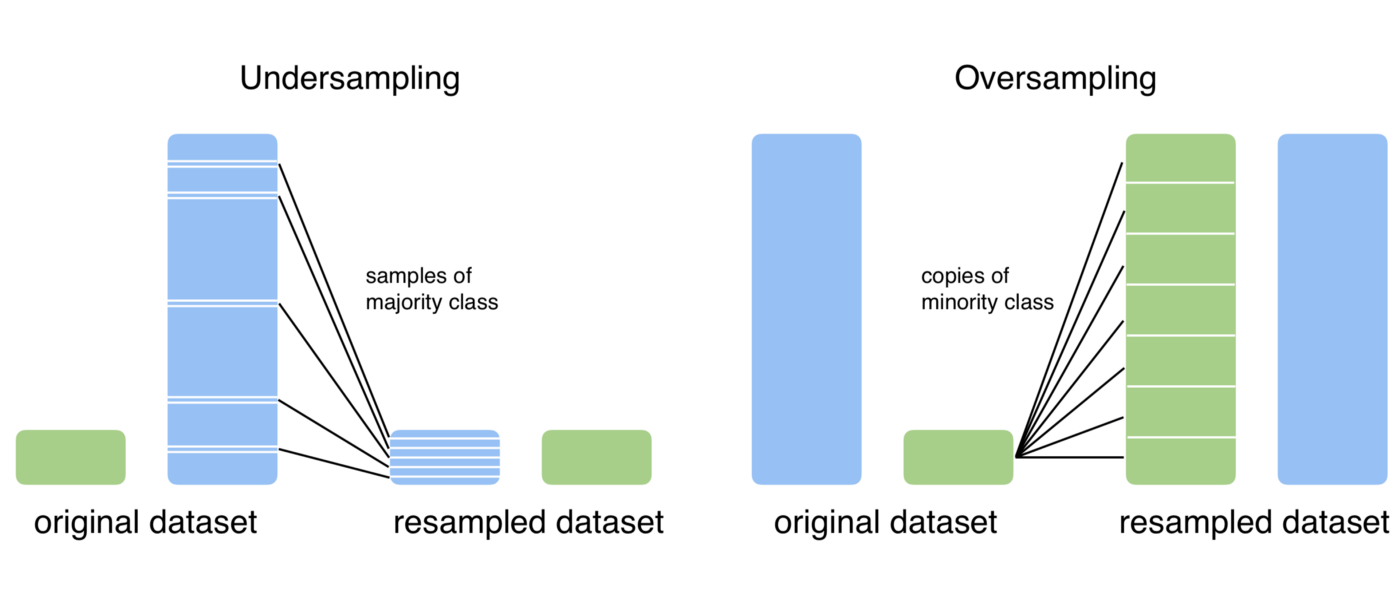

In [ ]:
#create two different dataframe of majority and minority class 
df_majority = df[(df['label']==0)] 
df_minority = df[(df['label']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 29720, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_sampled = pd.concat([df_minority_upsampled, df_majority])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


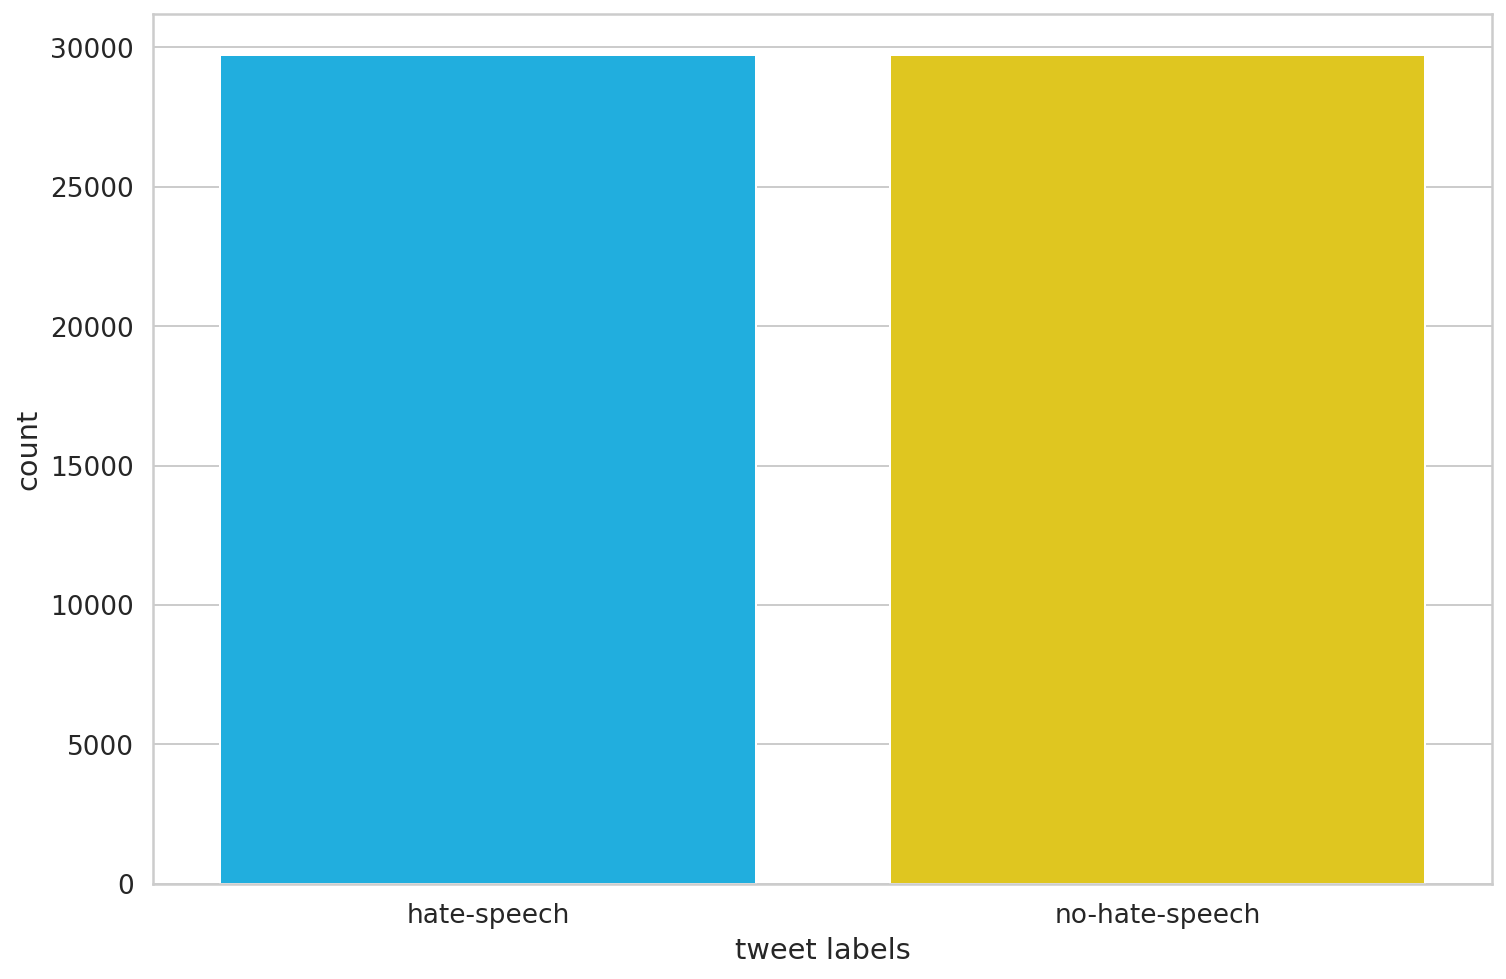

In [ ]:
# Plotting the tweets based on their label
sns.countplot(df_sampled.sentiment)
plt.xlabel('tweet labels');

Now the dataset is balanced and we can move on to data preprocessing.

Notice that there are other possible solutions for managing unbalanced datasets: undersampling (as you can see from the image), VAE, SMOTE, etc. We opted for the simplest one because, as we will see, it will be enough to obtain excellent results

To ensure a reasonable computational time for training we'll consider only a part of the dataset

In [ ]:
#Randomly sample 25% of 'hate-speech' labeled tweets and 25% of 'no-hate-speech' labeled tweets with seed value as Alberto's matriculation number
df_hate_speech = df_sampled[(df_sampled['sentiment']=='hate-speech')] .sample(frac = 0.25, random_state= 2026704)
df_no_hate_speech = df_sampled[(df_sampled['sentiment']=='no-hate-speech')] .sample(frac = 0.25, random_state= 2026704)
df = pd.concat([df_hate_speech, df_no_hate_speech])

##we sample 100% of the dataset df, which also shuffles it based on the matriculation number of Alberto
df = df.sample(len(df), random_state=2026704)
df.head()

,label,tweet,sentiment
22470,0,#highhopesstamps #retirement by donna using ...,no-hate-speech
1274,1,is a very profitable thing im #america,hate-speech
17128,0,@user @user @user not sure you understand what...,no-hate-speech
26252,1,"@user ""tackling systemic racism and our biases...",hate-speech
17208,1,@user 2016 is still alive ! black man is forc...,hate-speech


## Data Preprocessing

In this section with prepare data to run on the roBERTa pretrained model and the 'twitter-roberta-base-mar2022' for Sentiment Analysis pretrained model. 

roBERTa's requirements are:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (padding, truncation)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

In [ ]:
# Define the pretrained model name
PRE_TRAINED_MODEL_NAME = 'cardiffnlp/twitter-roberta-base-mar2022'

In [ ]:
# Load a pretraind tokenizer for roBERTa
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

### Choosing Sequence Length

roBERTa works with fixed-length sequences. We'll choose the max length by plotting the distribution of the token length for each tweet. 

In [ ]:
# List that will contain the length of each tweet in our dataset
token_lens = []
# Storing the number of tokens in each tweet in our dataset
for txt in df.tweet:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


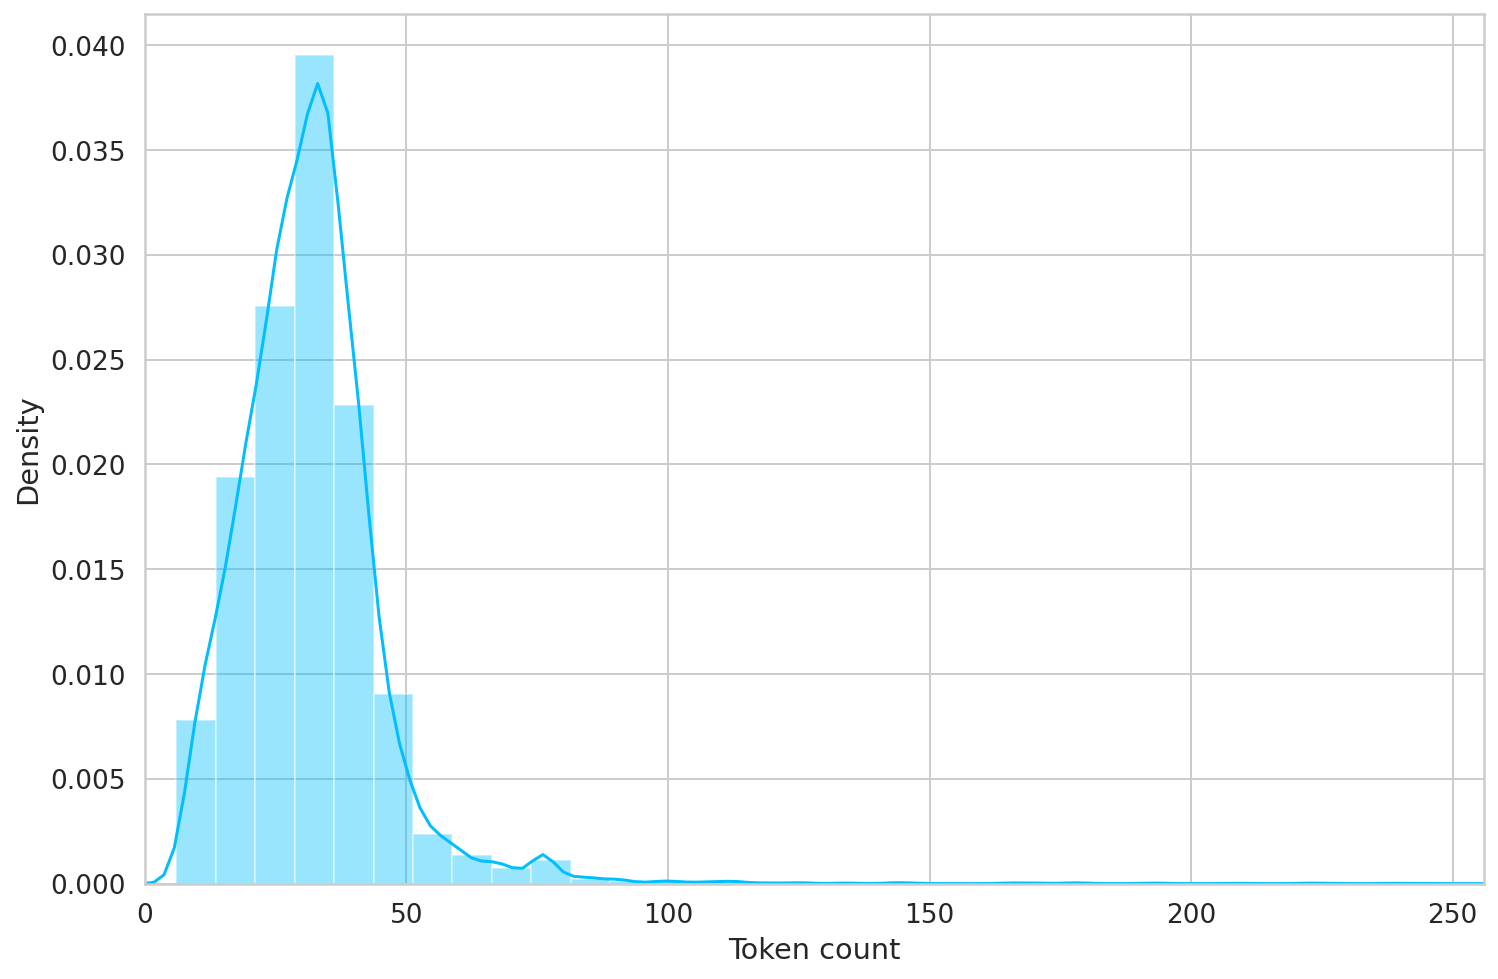

In [ ]:
# Plotting the lenght of tweets (i.e., the number of tokens per tweet) in our dataset
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the tweets seem to contain roughly 80 tokens, but we'll be on the safe side and choose a maximum length of 100.

In [ ]:
# Setting the sequence length to 100
MAX_LEN = 100

#### *TweetDataset* Dataset Class
We create a PyTorch dataset with the data processed so far.
- This class is defined to accept the Dataframe as input and generate tokenized output that is used by the RoBERTa model for training. 
- I am using the RoBERTa tokenizer to tokenize the data in the `tweet` column of the dataframe. 
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `input_ids`, `attention_mask`, `token_type_ids`
- `target` is the label assigned to the tweet. 
- The *TweetDataset* class is used to create 3 datasets, for training, validation and testing.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- The rest of the data (**20% of the original data**) is split as follows:
  - *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training.  
  - *Testing Dataset* is used to test the performance of the model. The model has not seen this data during training. 

In [ ]:
# PyTorch dataset class to handle the tweets dataset to have a uniform interface to access the training/test data.
class TweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    """
    Instantiation calss.

    :param self: self object.
    :param tweets: input tweets, i.e. the text of each tweet in the dataset.
    :param targets: target labels.
    :param tokenizer: tokenizer object.
    :param max_len: sequence length.

    :return an object of type TweetDataset.
    """
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    """
    Returns the size of the dataset.

    :param self: self object.

    :return int corresponding to the number of tweets in the dataset.
    """
    return len(self.tweets)
  
  def __getitem__(self, item):
    """
    Return the 𝑖-th data point in the dataset.

    :param self: self object.
    :param item: index of the data point to return

    :return dict containing the tweet text, input_ids, attention_mask and target label.
    """
    # tweet and target available from the object itself
    tweet = str(self.tweets[item])
    target = self.targets[item]

    # Tokenize the tweet through the encode_plus method
    inputs = self.tokenizer.encode_plus(
        tweet, # text to be encoded
        add_special_tokens=True, # encode special tokens needed for RoBERTa
        max_length=self.max_len, # maximum length
        padding='max_length', # pad the sequence to the max_len
        return_token_type_ids=True, # do return the token type IDs
        return_attention_mask=True, # return the attention mask
        truncation=True # explicitly truncate examples to max length 
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]


    return {
        'tweet_text': tweet,
        'input_ids': torch.tensor(ids, dtype=torch.long),
        'attention_mask': torch.tensor(mask, dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        'targets': torch.tensor(self.targets[item], dtype=torch.long)
    }

We now split the dataset into train, validation and test set. We do the usual 80-20 train/test split.

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

And check their size:

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((11888, 3), (1486, 3), (1486, 3))

We define a helper function to create data loaders. A data loader is a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  """
  Create a data loader object for the passed paramteres.

  :param df: (pandas.DataFrame) input data.
  :param tokenizer: (transformers.PreTrainedTokenizer) pretrained tokenizer.
  :param max_len: (int) maximum sequence length.
  :param batch_size: (int) number of samples to stack per batch.

  :return a DataLoader object.
  """
  # Create a GPTweetDataset object
  ds = TweetDataset(tweets=df.tweet.to_numpy(), 
                      targets=df.label.to_numpy(), 
                      tokenizer=tokenizer, 
                      max_len=max_len)

  return DataLoader(ds, 
                    batch_size=batch_size, 
                    num_workers=4) #num_workers: number of subprocesses to use for data loading.

We create the data loaders for train, validation and test sets.

In [ ]:
# Define the batch_size as a constant
BATCH_SIZE = 16

# Create a DataLoader object for training, validation and test data
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We take a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])

As expected the keys (non so di cosa) corresponds to the Pytorch dataset object we create. We now check for data shape and we expect them to be of size 16 as the batch size.

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


## Sentiment Classification with roBERTa and Hugging Face

We'll use the roBERTa model pretrained on tweets and build our sentiment classifier on top of it.
The roBERTa model was proposed in '[RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692)'  by Yinhan Liu et al. It is based on Google’s BERT model released in 2018.
It builds on BERT and modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

First we load the model.

In [ ]:
# Load the model
roberta_model = RobertaModel.from_pretrained("cardiffnlp/twitter-roberta-base-mar2022")

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-mar2022 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-mar2022 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

In [ ]:
# Check model hidden state size
roberta_model.config.hidden_size

768

We create a classifier that uses the RoBERTa model. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

In [ ]:
class RobertaClassifier(torch.nn.Module):
    def __init__(self, n_classes):
        """
        Instantiation class.

        :param self: self object.
        :param n_classes: number of classes (i.e., labels) to predict.

        :return a RobertaClassifier object.
        """
        super(RobertaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained("cardiffnlp/twitter-roberta-base-mar2022")
        self.pre_classifier = torch.nn.Linear(self.roberta.config.hidden_size, self.roberta.config.hidden_size)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(self.roberta.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):

        model_out = self.roberta(input_ids=input_ids, 
                              attention_mask=attention_mask, 
                              token_type_ids=token_type_ids) #take the output from RoBERTa pre-traied model
        hidden_state = model_out[0] #set the first hidden state
        pooler = hidden_state[:, 0] #slicing of the hidden state
        pooler = self.pre_classifier(pooler) #pre-stage where it apply a linear trasformation
        pooler = torch.nn.ReLU()(pooler) #ReLU as activation function to improve computation efficency
        pooler = self.dropout(pooler) #dropout to randomly switch off units during training
        output = self.classifier(pooler) #final layer
        return output

### Training

To reproduce the training procedure from the ROBERTA paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. 

For the sake of the project, we provide you with the model weights already trained with the parameters you see in the following cells. Therefore you can skip training the model and go to the evaluation section to load the trained model into memory. You still need to other cells of this section to run the evalutaion section.

**Parameters Setting** \
We ran some tests to decide the number of epochs. We trained the model for 10 epochs and printed the training history. As we can see from the image below after 3 epochs the system reached accuracy 1.0 on test set and show no further improvements therefore we decide to train our model for 3 epochs.

![picture](https://drive.google.com/uc?id=16Z13cUmcoE6Y4mMp50hPv83sxHTtltmf)

We create an instance of the RobertaClassifier model and move it to the GPU.

In [ ]:
model = RobertaClassifier(2) # Binary classification
model = model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-mar2022 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-mar2022 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

In [ ]:
# Useful parameters for training
EPOCHS = 3
LEARNING_RATE = 2e-5

# use the AdamW optimizer provided by Hugging Face.
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)

# Cross Entropy loss function
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


We wrote a helper function to train epochs.

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device
):
  """
  Train the model for an epoch.
  :param model: model to train.
  :param data_loader: data to be used to train the model.
  :param loss_fn: loss function.
  :param optimizer: optimizer function to be used.
  :param device: where to run the training.

  :return training accuracy, training loss.
  """
  # Set model to training mode
  model = model.train()
  # training loss
  tr_loss = 0
  # number of correct predictions
  correct_predictions = 0
  # number of training steps
  nb_tr_steps = 0
  # number of training examples 
  nb_tr_examples = 0
  # Loop over data
  for count,d in tqdm(enumerate(data_loader, 0)):

    # move data to the device
    input_ids = d["input_ids"].to(device, dtype=torch.long)
    attention_mask = d["attention_mask"].to(device, dtype=torch.long)
    token_type_ids = d["token_type_ids"].to(device, dtype=torch.long)
    targets = d["targets"].to(device, dtype=torch.long)

    # model prediction
    outputs = model(
      input_ids = input_ids,
      attention_mask = attention_mask,
      token_type_ids = token_type_ids
    )
    _, preds = torch.max(outputs, dim=1)
    # calculate the loss
    loss = loss_fn(outputs, targets)
    # Update correct predictions and append new loss
    correct_predictions += torch.sum(preds == targets)
    tr_loss += loss.item()

    # Update countes
    nb_tr_steps += 1
    nb_tr_examples += targets.size(0)

    # printing training loss and training accuracy every 5000 steps
    if count%5000==0:
        loss_step = tr_loss/nb_tr_steps
        acc_step = correct_predictions/nb_tr_examples
        print(f"\nTraining Loss per 5000 steps: {loss_step}")
        print(f"Training Accuracy per 5000 steps: {acc_step}")

    # before calculating the gradients, we need to ensure that they are all zero
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # update the parameters
    optimizer.step()

  return correct_predictions/nb_tr_examples, tr_loss/nb_tr_steps


We wrote a helper function to evaluate the model on a given data loader

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
  """
  Evaluate the model for an epoch.
  :param model: model to train.
  :param data_loader: data to be used to train the model.
  :param loss_fn: loss function.
  :param device: where to run the training.

  :return validation accuracy, validation loss.
  """
  # Set model to evaluation mode
  model = model.eval()
  correct_predictions = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
  # deactivate gradients
  with torch.no_grad():
    # loop over data
    for count, d in tqdm(enumerate(data_loader, 0)):
      # move data to the device
      input_ids = d['input_ids'].to(device, dtype = torch.long)
      attention_mask = d['attention_mask'].to(device, dtype = torch.long)
      token_type_ids = d['token_type_ids'].to(device, dtype=torch.long)
      targets = d['targets'].to(device, dtype = torch.long)

      # model prediction
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )

      _, preds = torch.max(outputs, dim=1)

      # calculate the loss function
      loss = loss_fn(outputs, targets)

      # update validation accuracy and loss
      correct_predictions += torch.sum(preds == targets)
      tr_loss += loss.item()

      # update counters
      nb_tr_steps += 1
      nb_tr_examples+=targets.size(0)

      if count%5000==0:
          loss_step = tr_loss/nb_tr_steps
          acc_step = correct_predictions/nb_tr_examples
          print(f"\nValidation Loss per 100 steps: {loss_step}")
          print(f"Validation Accuracy per 100 steps: {acc_step}")

    return correct_predictions/nb_tr_examples, tr_loss/nb_tr_steps


We wrote the training loop using the functions defined above and store the training history.

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  # Training phase
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device
  )
  print(f'\nTrain loss {train_loss} \nTrain accuracy {train_acc}')

  # Validation Phase
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device
  )
  print(f'\nValidation loss {val_loss} \nValidation accuracy {val_acc}')
  print()

  # Storing accuracy and loss in history
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    # storing best states so far
    best_states = model.state_dict()
    # storing best model so far
    best_model = model
    # updating best accuracy
    best_accuracy = val_acc
    

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
1it [00:00,  2.98it/s]


Training Loss per 5000 steps: 0.7255113124847412
Training Accuracy per 5000 steps: 0.5


743it [03:29,  3.55it/s]


Train loss 0.18921047453624404 
Train accuracy 0.9263122081756592



2it [00:00, 10.56it/s]


Validation Loss per 100 steps: 0.18186813592910767
Validation Accuracy per 100 steps: 0.9375


93it [00:08, 10.54it/s]


Validation loss 0.08517675891378394 
Validation accuracy 0.9710632562637329

Epoch 2/3
----------



1it [00:00,  2.88it/s]


Training Loss per 5000 steps: 0.14481689035892487
Training Accuracy per 5000 steps: 0.9375


743it [03:34,  3.47it/s]


Train loss 0.04429797338892757 
Train accuracy 0.9854474663734436



3it [00:00, 10.14it/s]


Validation Loss per 100 steps: 0.33610132336616516
Validation Accuracy per 100 steps: 0.875


93it [00:08, 10.68it/s]


Validation loss 0.10056353515822701 
Validation accuracy 0.9717361927032471

Epoch 3/3
----------



1it [00:00,  3.12it/s]


Training Loss per 5000 steps: 0.037871792912483215
Training Accuracy per 5000 steps: 1.0


743it [03:34,  3.47it/s]


Train loss 0.020066729733852193 
Train accuracy 0.993943452835083



2it [00:00,  9.42it/s]


Validation Loss per 100 steps: 0.06909996271133423
Validation Accuracy per 100 steps: 0.9375


93it [00:08, 10.59it/s]


Validation loss 0.058063778837095015 
Validation accuracy 0.982503354549408

CPU times: user 7min 28s, sys: 3min 11s, total: 10min 40s
Wall time: 11min 6s


In [ ]:
# Saving best model parameters
torch.save(best_states, 'best_model_state.bin')
# Saving the model
torch.save(best_model, "roberta_tweets_model.bin")

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

We can now take a look at the training vs validation accuracy:

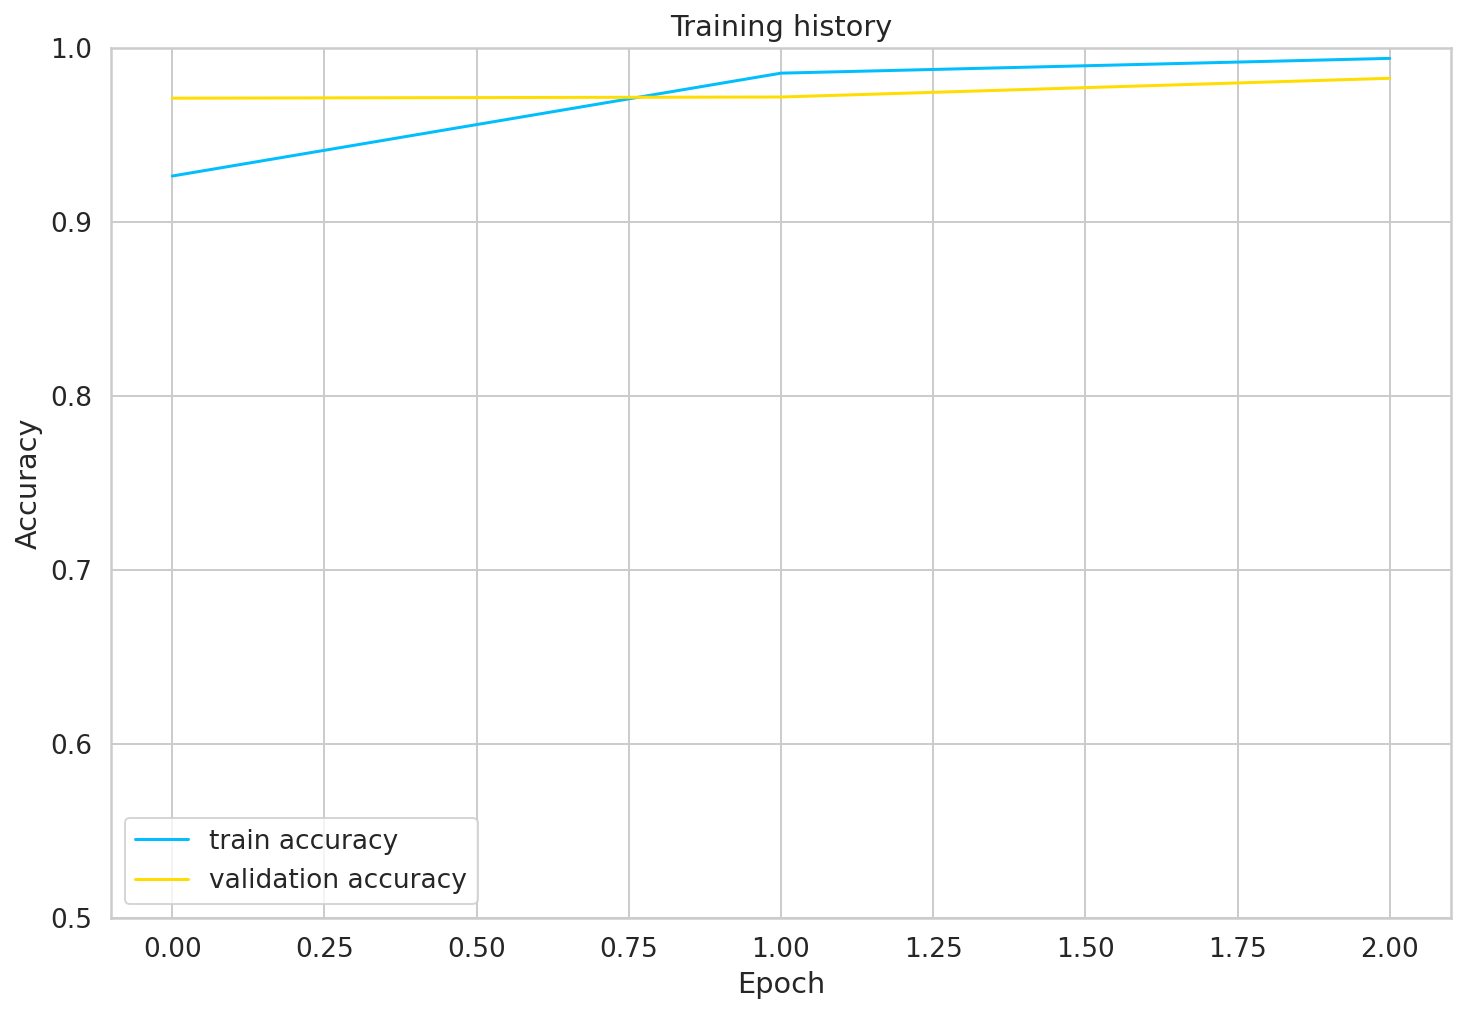

In [ ]:
# Plotting training and validation history

# Moving Tensors to cpu to prevent AttributeError when plotting
history['train_acc'] = [x.cpu() for x in history['train_acc']]
history['val_acc'] = [x.cpu() for x in history['val_acc']]

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);

The model we'are relying on is a pre-trained model and already quite accurate. We can see it from the fact that the accuracy of our training begins to approach 100% immediately at the first epoch.

## Evaluation

In order to test how good our model is we start by calculating the accuracy on the test data.

In [ ]:
# TO RUN ONLY IF THE MODEL HAS NOT BEEN TRAINED

# download the trained weights for the model
!gdown --id 1DtMoK78soMP2ya5NWe6nYQjAXPbViqvh

# create an instance of the model
model = RobertaClassifier(2)
# load the weights
model.load_state_dict(torch.load('best_model_state.bin'))
# move the modle to the GPU
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1DtMoK78soMP2ya5NWe6nYQjAXPbViqvh
To: /content/best_model_state.bin
100% 501M/501M [00:05<00:00, 98.8MB/s]


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-mar2022 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-mar2022 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

In [ ]:
# Evaluate the model on the test data
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device
)

print(f'\nAccuracy on test set {test_acc.item()}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2it [00:00,  5.67it/s]


Validation Loss per 100 steps: 0.0004959649522788823
Validation Accuracy per 100 steps: 1.0


93it [00:08, 11.62it/s]


Accuracy on test set 0.9858680963516235


Basically, the accuracy on test set can be considered the same to the accuracy of the training, which makes it an excellent result.

We define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  """
  Return the predictions from the model passed as argument.

  :param model: model to be used to get the predictions.
  :param data_loader: data for which we want to get the predictions.

  :return tweet texts, predicted labels, prediction probabilities and real labels.
  """
  # set model to evaluation mode
  model = model.eval()
  
  # List containing tweet texts
  tweet_texts = []
  # List containing the predicted label
  predictions = []
  # List containing the probability of the predicted label
  prediction_probs = []
  # List containt the real label assigned to each tweet
  real_values = []

  # deactivate gradient
  with torch.no_grad():
    # loop over data
    for d in data_loader:

      # retrive tweet text from the data_loader
      texts = d["tweet_text"]
      # move data to the device
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      token_type_ids = d['token_type_ids'].to(device)

      # model prediction
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      # predicted probabilities (softmax on the model outputs)
      probs = F.softmax(outputs, dim=1)

      # add retrieved data to the end of the list
      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  # move data to the cpu
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the tweets and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
#we store the text of the tweets and predicted probabilities
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We analyze the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

                precision    recall  f1-score   support

no-hate-speech       0.99      0.98      0.99       729
   hate-speech       0.98      0.99      0.99       757

      accuracy                           0.99      1486
     macro avg       0.99      0.99      0.99      1486
  weighted avg       0.99      0.99      0.99      1486



The report gives us an excellent result of the performance measures. The **recall** (TP/TP+FN) is slightly better for 'hate-speech' label. The **precison** (TP/TP+FP), on the contrary has an higher value for 'no-hate-speech' label. Therefore, the **f1-score** (weighted average of Precision and Recall) is unchanged between both labels.

We'll continue with the confusion matrix:

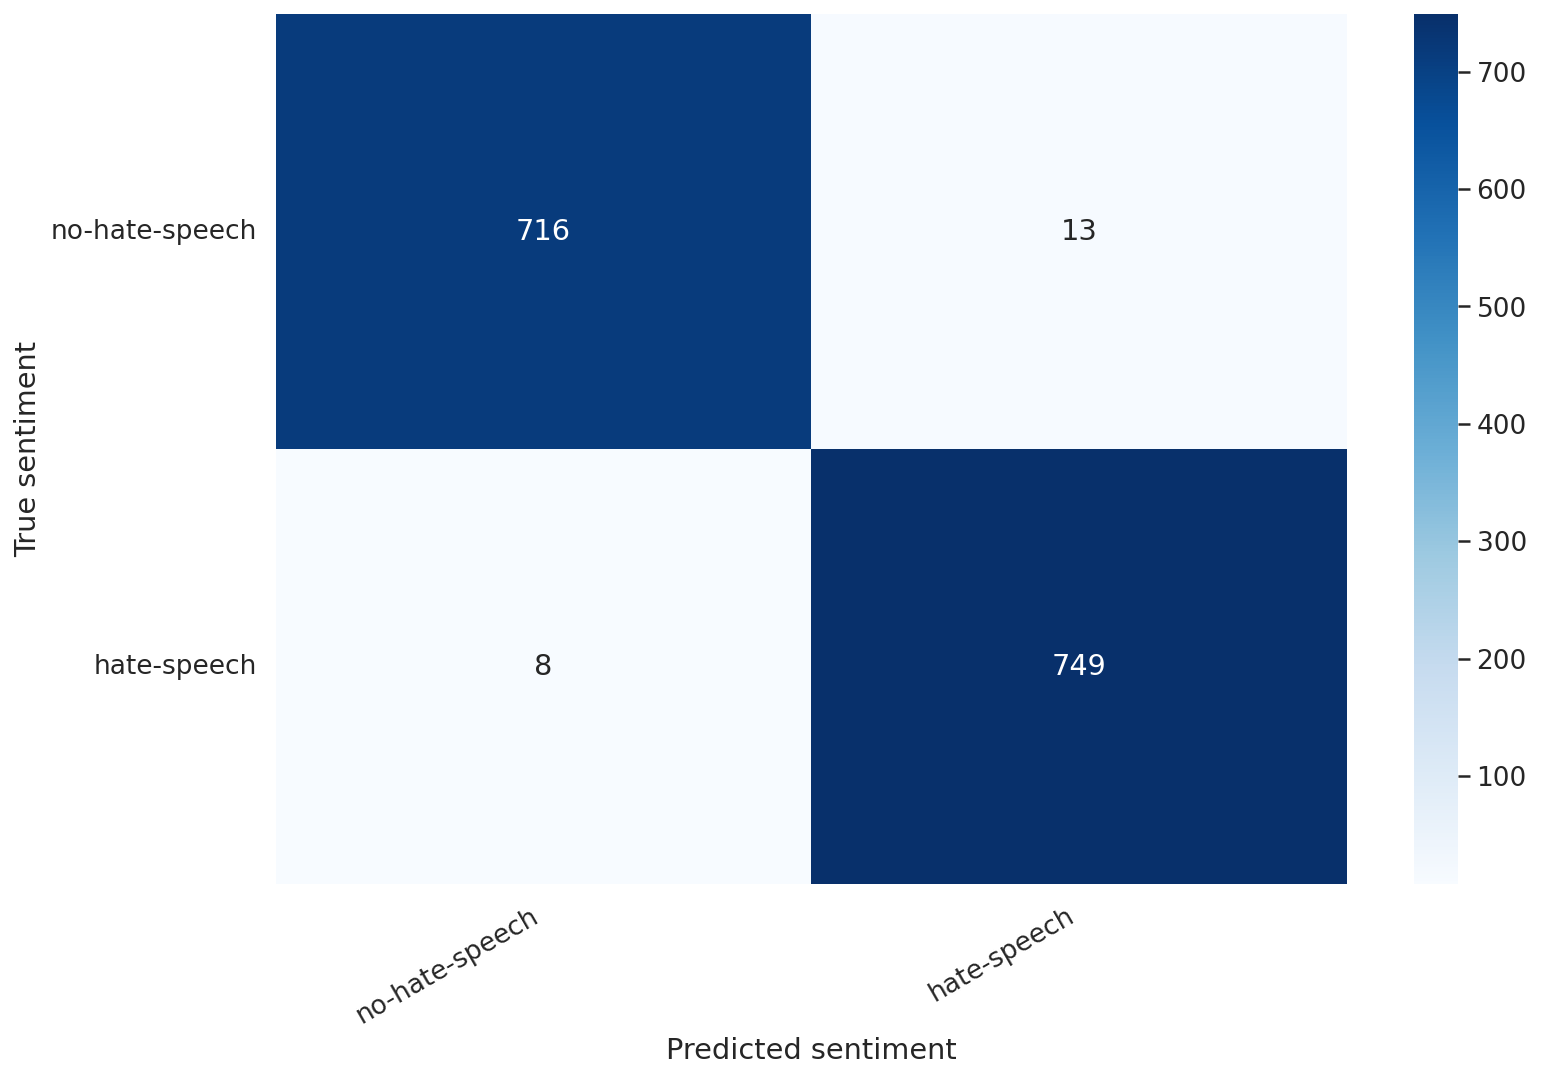

In [ ]:
#define a function for confucsion matrix
def show_confusion_matrix(confusion_matrix):
  """
  Function to display the confusion matrix
  """
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

The model seems to have more difficulty in classifying the no-hate-speech since the frequency of misclassifed samples is slighly higher for this label. Anyway, we are talking about details that are negligible in practice.

The model has has a slight difficulty classifying neither hate-speech nor non-hate-speech, in fact, it mistakes those for negative and positive at equal frequency (very low).

Let's take a look to a specific sample calssification.

In [ ]:
#check for those samples that have a wrong prediction w.r.t the true sentiment
text_mis = []
pred = []
sentiment =[]
for idx in range(len(y_tweet_texts)) :  
  tweet_text = y_tweet_texts[idx]
  true_sentiment = y_test[idx]
  prediction = y_pred[idx]
  if int(true_sentiment) != prediction: #look for a misclassified sample
    text_mis.append(tweet_text)
    sentiment.append(true_sentiment)
    pred_df= pd.DataFrame({
      'class_names': class_names,
      'values': y_pred_probs[idx]
      })
    pred.append(pred_df)

Take a look to the confidence of each sentiment

please stop violence! - talk listen respect empathy love! #orlando
â¦

True sentiment: no-hate-speech


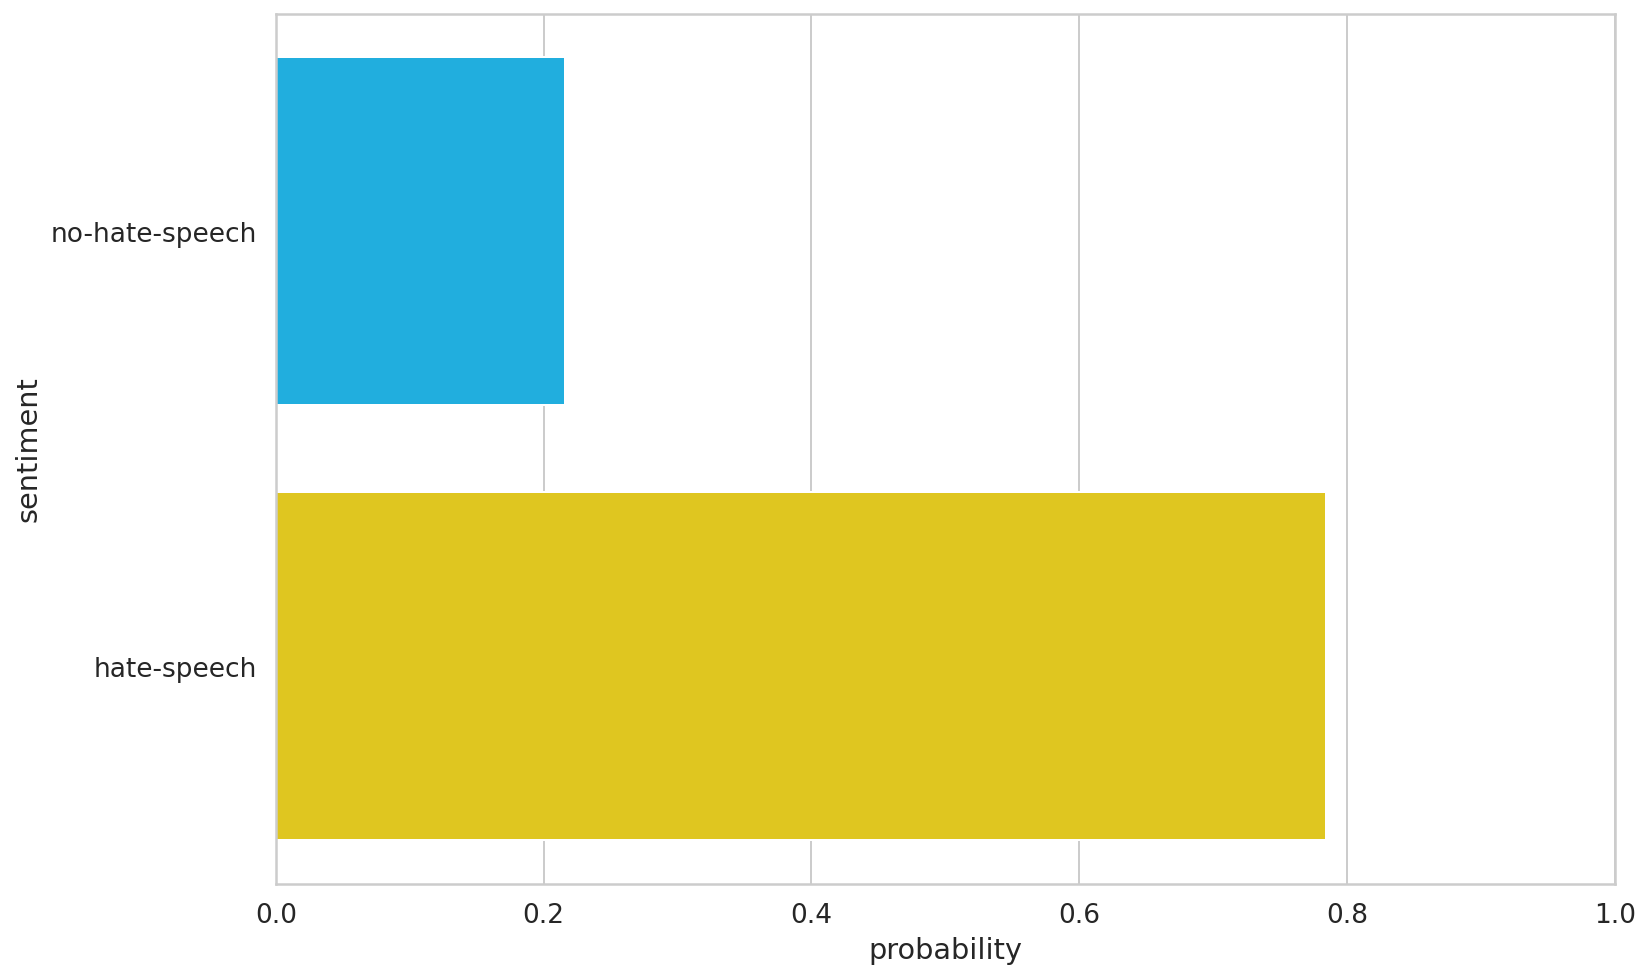

In [ ]:
#we selected arbitrarly one of the 21 misclassifed sample
print("\n".join(wrap(text_mis[8])))
print()
print(f'True sentiment: {class_names[sentiment[8]]}')

sns.barplot(x='values', y='class_names', data=pred[8], orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

The true sentiment for this text is 'no-hate-speech' but it was misclassified by the model in 'hate-speech'. Probably the reason why the model misclassify is due to the presence of word 'violence'. Anyway, a discrete probability was assigned also to the non-hate speech label.



### Test on raw text
Let's test now our model with some raw text.

The [Council of Europe](https://www.rightsforpeace.org/hate-speech) in 1997 has defined hate speech as:

“all forms of expression which spread, incite, promote, or justify racial hatred, xenophobia, anti-Semitism or other forms of hatred based on intolerance.”

let's pass this sentence as input to our model!

In [ ]:
review_text = "all forms of expression which spread, incite, promote, or justify racial hatred, xenophobia, anti-Semitism or other forms of hatred based on intolerance."

In [ ]:
#token_type_ids = encoded_review["token_type_ids"]
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
token_type_ids = encoded_review ['token_type_ids'].to(device)

output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: all forms of expression which spread, incite, promote, or justify racial hatred, xenophobia, anti-Semitism or other forms of hatred based on intolerance.
Sentiment  : hate-speech


It is very courious because the model classified the definition of hate speech as hate speech. Probably because it includes some terms related to the sphere of racism and discrimination such as hatred, xenophobia, anti-Semitism. 

On this notebook we fine-tuned a RoBERTa model for classifying tweets in 'no-hate-speech'/'hate-speech'. We discovered our model obtained very good results in terms of accuracy, namely 98% accuracy on the test set. We also seen that however accurate it is, it still remains imperfect and far from human accuracy. 